<a href="https://colab.research.google.com/github/rahiakela/computer-vision-research-and-practice/blob/main/embedding-methods-for-image-search/01_building_color_histograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building Color Histograms

To build our histograms we will be relying primarily on the OpenCV and Numpy libraries.

* **OpenCV** is a popular **C**omputer **V**ision (CV) library, it's full of useful image load/save and manipulation functions.
* **NumPy** is a very popular library focused on providing optimized numerical operations for multi-dimensional arrays.

##Setup

In [ ]:
!pip install opencv-python numpy datasets

In [2]:
from datasets import load_dataset

from base64 import b64decode
import cv2
import numpy as np
import matplotlib.pyplot as plt

Let's get a set of images, we will use the `pinecone/image-set` dataset from HuggingFace datasets:

In [30]:
data = load_dataset("pinecone/image-set", split="train", revision="e7d39fc")
data

Dataset({
    features: ['image_bytes', 'image'],
    num_rows: 21
})

Inside the *image_bytes* feature we have base64 encoded bytes representation of the images, we can decode them into Numpy arrays using the Open-CV library like so:

In [4]:
def process_fn(sample):
  image_bytes = b64decode(sample["image_bytes"])
  image = cv2.imdecode(np.frombuffer(image_bytes, np.uint8), cv2.IMREAD_COLOR)
  return image

images = [process_fn(sample) for sample in data]

We can display images with matplotlib.

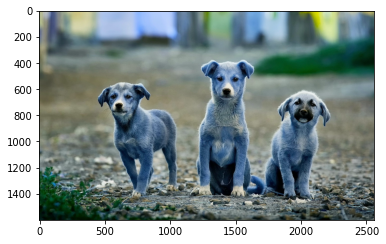

In [5]:
plt.imshow(images[0])

The three dogs look strangely blue; that’s not intentional. OpenCV loads images in a Blue Green Red (BGR) format. Matplotlib expected RGB, so we must flip the color channels of the array to get the true color image.

<img src='https://d33wubrfki0l68.cloudfront.net/aa211c64e2500d0df325a98384b90ceaad22f084/3c750/images/color-histograms-5.png' width='600'/>


In [6]:
shape = images[0].shape
shape, images[0][0, 0, :]

rgb_image = np.flip(images[0], 2)

shape = rgb_image.shape
shape, rgb_image[0, 0, :]

((1600, 2560, 3), array([134, 174, 165], dtype=uint8))

Note that while the `shape` of the array has remained the same, the three values have been reversed (those three values are the BGR -> RGB values for a single pixel in the images).

Now we can visualize in real color.

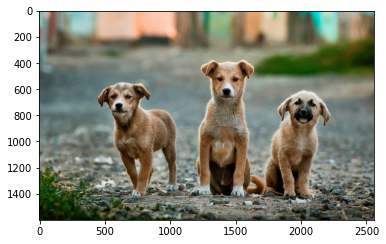

In [7]:
plt.imshow(rgb_image)

##Building Histogram Step-by-Step

To help us understand how an image is transformed into a color histogram we will work through a step-by-step example using Numpy.

We already have our Numpy arrays. 

For the first image we can see the three BGR color values at pixel zero with:

In [8]:
images[0][0, 0, :]

array([165, 174, 134], dtype=uint8)

Each pixel has a **B**lue, **G**reen, and **R**ed activation value on a scale from `0` (no color) to `255` (max color).

We can see this by plotting the following colors by simply modifying the RGB values (remember they are inverted from BGR to RGB between OpenCV and Matplotlib):

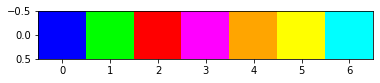

In [10]:
blue = [0, 0, 255]
green = [0, 255, 0]
red = [255, 0, 0]
violet = [255, 0, 255]
orange = [255, 165, 0]
yellow = [255, 255, 0]
cyan = [0, 255, 255]

colors = np.asarray([[blue, green, red, violet, orange, yellow, cyan]])
plt.imshow(colors)

From the first pixel of our image with the three dogs, we have the BGR values:

| Blue | Green | Red |
| --- | --- | --- |
| 165 | 174 | 134 |

We can estimate that the first pixel will be a slight blue-green color (as these both overpower the red value, albeit slightly). We can see the pixel here in the top-left corner:

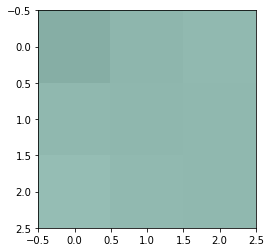

In [11]:
plt.imshow(rgb_image[:3, :3, :])

The color channel values for all pixels in the image are presently stored in an array of equal dimensions to the original image. 

When comparing image embeddings the most efficient techniques rely on comparing vectors not arrays. 

To handle this, we first reshape the rows and columns of the image array into a single row.

In [13]:
rgb_image.shape

(1600, 2560, 3)

In [12]:
image_vector = rgb_image.reshape(1, -1, 3)
image_vector.shape

(1, 4096000, 3)

We can see that the top left three pixels are still the same:

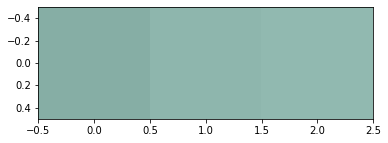

In [15]:
plt.imshow(image_vector[:, :3, :])

Even now, we still don’t have a “vector” because there are three color channels. 

We must extract those into their own vectors (and later during comparison we will concatenate them to form a single vector).

In [18]:
red = image_vector[0, :, 0]
green = image_vector[0, :, 1]
blue = image_vector[0, :, 2]

red.shape, green.shape, blue.shape

((4096000,), (4096000,), (4096000,))

Now we visualize each with a histogram.

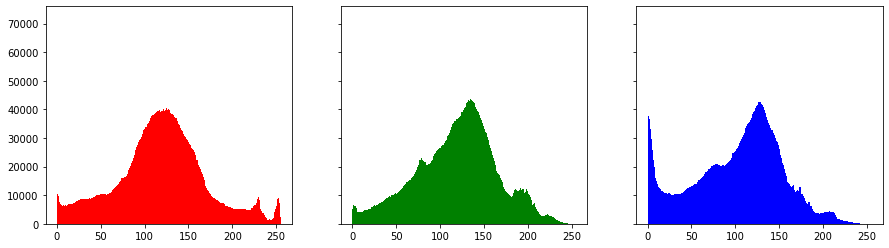

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].hist(red, bins=256, color="r")
axs[1].hist(green, bins=256, color="g")
axs[2].hist(blue, bins=256, color="b")
plt.show()

Here we can see the three color channels, on the x-axis we have the pixel color value (from *0 -> 255*) and on the y-axis we see the total number of pixels with that color value.

Typically, we would discretize the histograms into a smaller number of bins. We will add this to a function called `build_histogram` that will take our image array `image` and a number of `bins` and build a histogram for us.


In [21]:
def build_histogram(image, bins=256):
  # convert from BGR to RGB
  rgb_image = np.flip(image, 2)
  # show the image
  plt.imshow(rgb_image)
  # convert to a vector
  image_vector = rgb_image.reshape(1, -1, 3)
  # break into given number of bins
  div = 256 / bins
  bins_vector = (image_vector / div).astype(int)
  # get the red, green, and blue channels
  red = bins_vector[0, :, 0]
  green = bins_vector[0, :, 1]
  blue = bins_vector[0, :, 2]
  # build the histograms
  fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
  axs[0].hist(red, bins=256, color="r")
  axs[1].hist(green, bins=256, color="g")
  axs[2].hist(blue, bins=256, color="b")
  plt.show()

We can apply this to a few images to get an idea of how the color profile of an image can change the histograms.

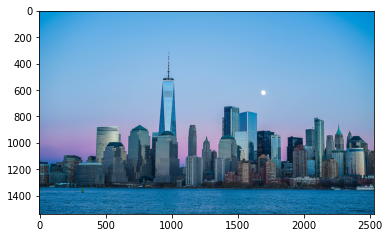

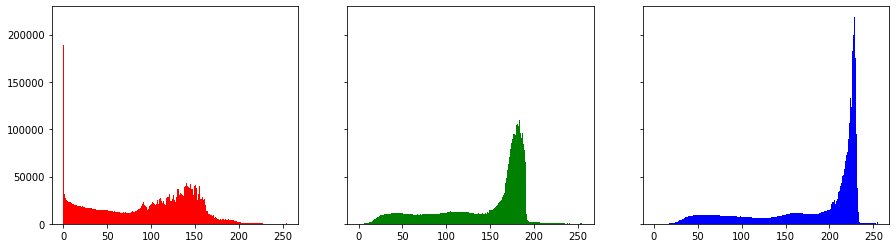

In [23]:
# we will see a lot of blue in this image, and it shows
# as high counts in high values in the blue histogram
build_histogram(images[1])

One thing I added to this formula is the option to reduce the number of bins we are visualizing, eg rather than visualize every color value (0 -> 255) as a single bar, we can visualize values [0-4, 5-9, 10-14, ...] together using the `bins` parameter.

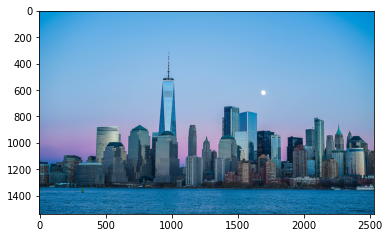

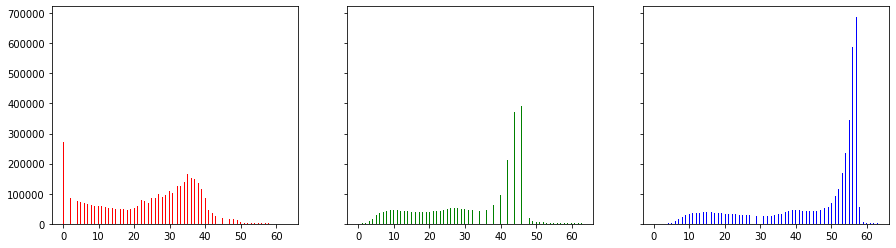

In [24]:
build_histogram(images[1], 64)

This can be great for reducing the size of our image representations while still keeping as much information as possible.

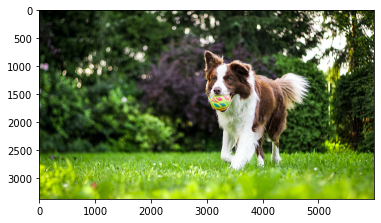

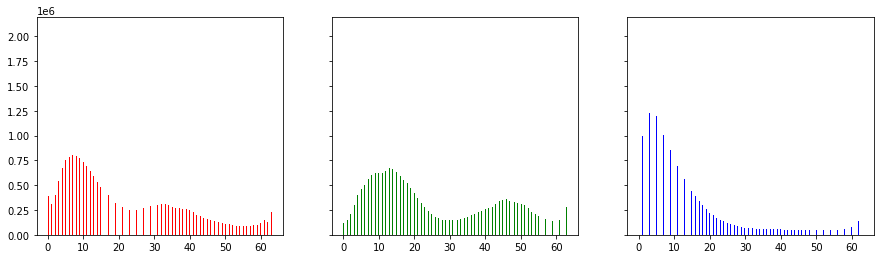

In [25]:
# very little blue in this image, and it shows as high counts in *low* values of the blue histogram
build_histogram(images[2], 64)

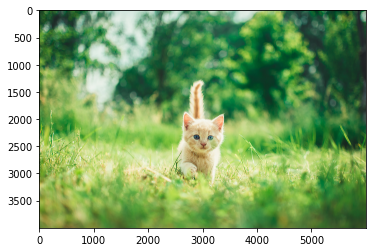

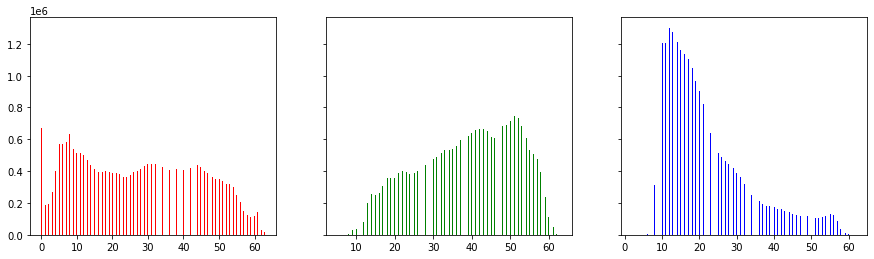

In [26]:
# blue again is very low, plenty of green
build_histogram(images[3], 64)

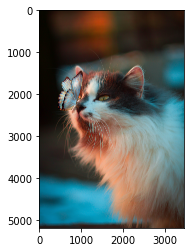

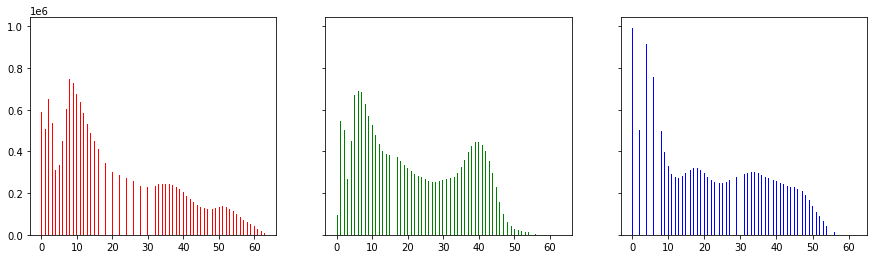

In [27]:
build_histogram(images[4], 64)

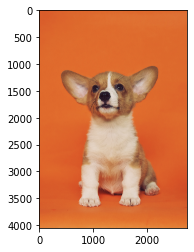

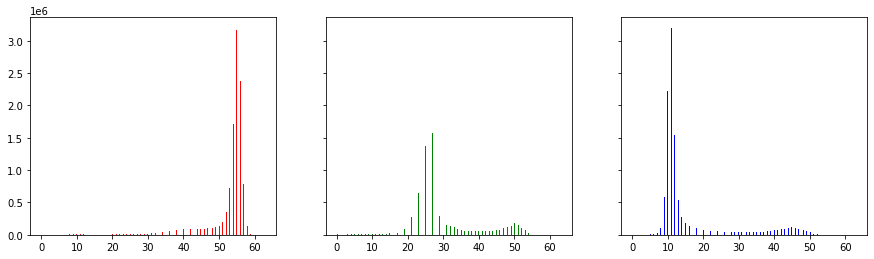

In [28]:
# there is little variation in color here, shown by the isolated spikes
build_histogram(images[5], 64)

Okay so that is the *slow way* of building histograms, hopefully it's very clear how this works. But how can we do this more efficiently?

##Building Histograms using OpenCV

Building histograms can be abstracted to be done more easily using the OpenCV library. OpenCV has a function called `calcHist` specifically for building histograms. 

We apply it like so:

In [29]:
red_hist = cv2.calcHist([images[5]], [2], None, [64], [0, 256])
green_hist = cv2.calcHist([images[5]], [1], None, [64], [0, 256])
blue_hist = cv2.calcHist([images[5]], [0], None, [64], [0, 256])

red_hist.shape

(64, 1)

The values used here are:

```
cv2.calcHist([images], [channels], [mask], [bins], [hist_range])
```

Where:
* `images` is our cv2 loaded image with channels blue, green, red. This argument expects a list of images which is why we have placed our single image inside square brackets `[]`.
* `channels` is the color channel (BGR) that we'd like to create a histogram for. We do this for a single channel at once.
* `mask` is another image (or list of images) consisting of `0` and `1` values that allow us to *mask* part of the `images` if wanted, we don't want to do this so we set it to `None`.
* `bins` is as before, the number of bins/ranges that we want to place our values in. We can set this to `256` if we'd like to keep the original values.
* `hist_range` is the range of color values we would expect. As we're using RGB we expect a min value of `0` and max value of `255`, so we write `[0, 256]` (the upper limit is exclusive, not inclusive).

<img src='https://d33wubrfki0l68.cloudfront.net/b1fff96b771177a9c74cf54bf262e64345a4bf7a/7733c/images/color-histograms-4.png' width='600'/>

After calculating these histogram values we can visualize them again using plot.

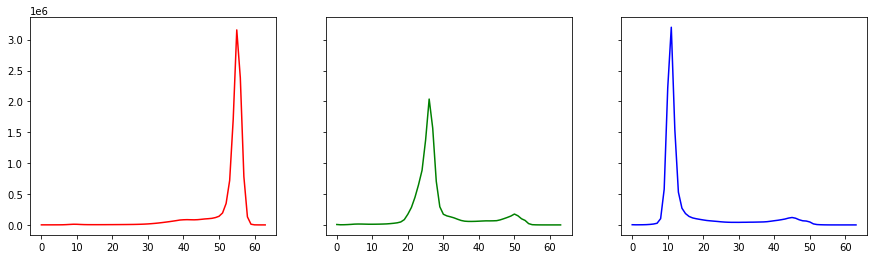

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
axs[0].plot(red_hist, color="r")
axs[1].plot(green_hist, color="g")
axs[2].plot(blue_hist, color="b")
plt.show()

The `calcHist` function has effectively performed the same operation but with much less code. We now have our histograms; however, we’re not done yet.